In [194]:
import pandas as pd
import numpy as np
from datetime import datetime
import altair as alt
from IPython import display

# Load and cleanup data


We load user activity data and cloud cost data for the duration of the semester
into pandas dataframes. We make sure our timezones are right, and that we fill in
NaNs where we have missing data.

In [190]:
semester_start = pd.Timestamp('2018-08-15').tz_localize('US/Pacific')
semester_end = pd.Timestamp('2018-12-15').tz_localize('US/Pacific')

In [191]:
# Log data for user activity
path_usage = '../data/processed/fall-2018/user-activity.jsonl'
datahub = pd.read_json(path_usage, lines=True)

# Index by timestamp
datahub = datahub.set_index('timestamp')

# Our timestamps are in UTC
datahub = datahub.tz_localize('UTC')
# But we want them in US/Pacific, since that's how our billing data is setup
datahub = datahub.tz_convert('US/Pacific')
# Only between start and end of semester
datahub = datahub[datahub.index > semester_start][datahub.index < semester_end]

In [192]:
# Cost per day, in PST
cost = pd.read_json('../data/processed/fall-2018/cloud-costs.jsonl', lines=True)

cost = cost.set_index('start_time')
cost = cost.drop(columns=['end_time'])
# Pandas' read_json reads dates in as UTC, but since our *actual* dates for cloud costs are in PST, we convert back
cost = cost.tz_localize('UTC')
cost = cost.tz_convert('US/Pacific')

# Only between start and end of semester
cost = cost[cost.index > semester_start][cost.index < semester_end]
# We only use indexing timestamps to make the tz_localize easier.
# after that, we drop it to make everything else easier
cost = cost.reset_index()

# Fill in any missing data before beginning of date
missing_dates = pd.date_range(semester_start, cost.start_time.min(), name='start_time')
missing_dates_cost = pd.DataFrame(missing_dates, np.full(len(missing_dates), np.nan), columns={'start_time', 'cost'})
cost = cost.append(missing_dates_cost)

# Metrics

We munge our raw data into specific metrics we care about

## Daily Active user

We count someone as a 'daily active user' if they start / stop their notebook server
at least once. Due to anonimization techniques applied earlier, this might slightly
under count users

In [175]:
# Unique daily users - we count anyone who has logged in at least once a day
# We want a dataframe with no index so we can use it easily with Altair
daily_active_users = pd.DataFrame(datahub['user'].resample('D').nunique()).reset_index()

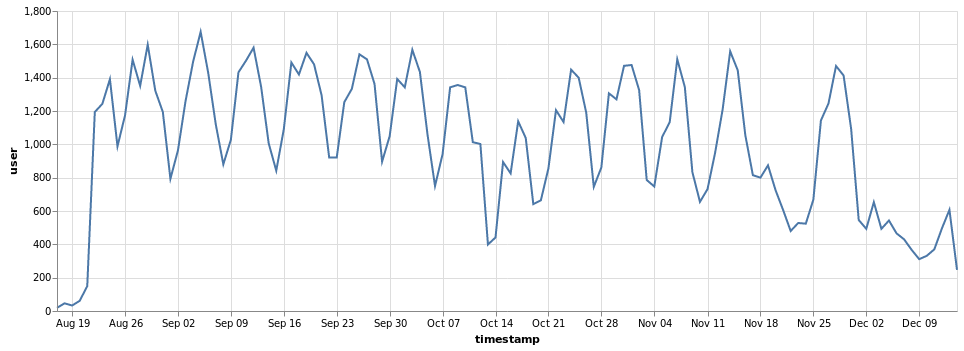

In [176]:
alt.Chart(daily_active_users, width=900).mark_line().encode(
    x='timestamp',
    y='user'
)

In [199]:
# Mean daily active users
mean_daily_active_users = daily_active_users['user'].mean()
display.HTML(f'<h3>Mean daily active users: <b>{mean_daily_active_users}</b></h3>')

## Daily cloud costs

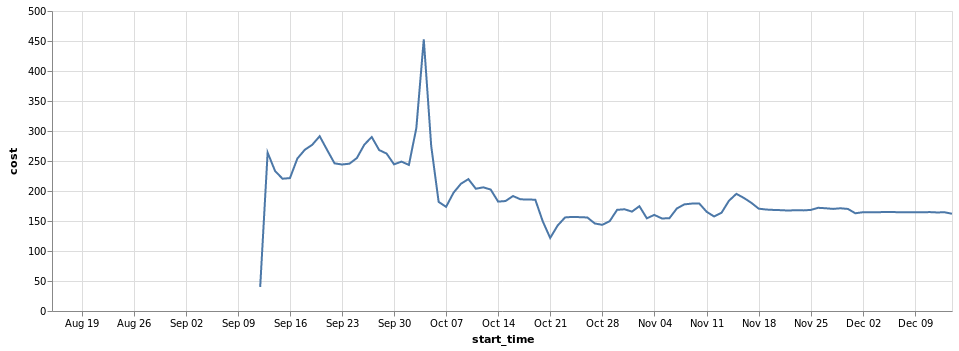

In [200]:
alt.Chart(cost, width=900).mark_line().encode(
    x='start_time',
    y='cost'
)

In [204]:
# Mean daily active users
mean_cost = cost['cost'].mean()
display.HTML(f'<h3>Mean daily cloud cost: <b>${mean_cost}</b></h3>')

## Daily cloud costs per **active** user

This is cost per day for *active* users - those who used the cluster. This is only a fraction of your total users, so be careful using this for estimates.

In [205]:
# Combine into a single dataframe based on day
total = pd.merge(daily_active_users, cost, how='outer', left_on='timestamp', right_on='start_time').drop(columns=['start_time'])

# Calculate daily cost per user
total['cost_per_active_user'] = total['cost'] / total['user']

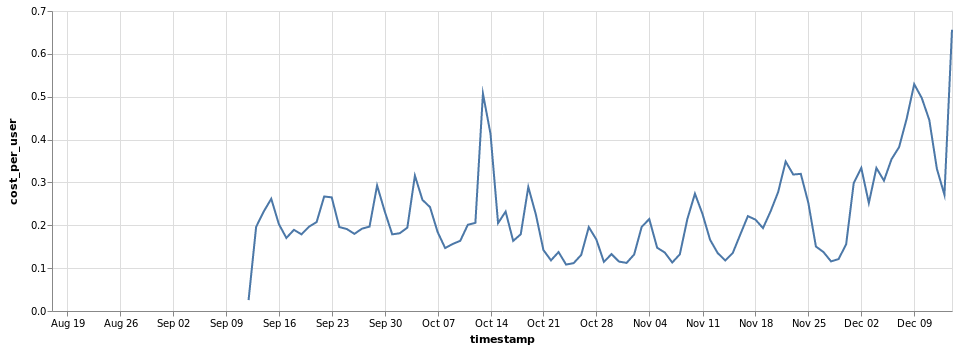

In [206]:
alt.Chart(total, width=900).mark_line().encode(
    x='timestamp',
    y='cost_per_active_user'
)

## Total Users

One way to count the 'number of users on the JupyterHub' is to look at everyone who has ever started a notebook. Since anyone with a Berkeley.edu account can log in, this is not the most accurate count of people who *use* the hub - but it's useful nonetheless.

In [277]:
user_starts_count = datahub[datahub.action == 'start'].groupby(['user']).count()
display.HTML(f'<h4>Users who used JupyterHub at least once: <b>{user_starts_count.count()["action"]}</b></h4>')

Some basic stats about number of times users started their servers

In [278]:
user_starts_count.describe()

,action
count,4860.000000
mean,46.464609
std,59.677874
min,1.000000
25%,2.000000
50%,15.000000
75%,79.000000
max,425.000000


We can calculate cost per day per user from this user count

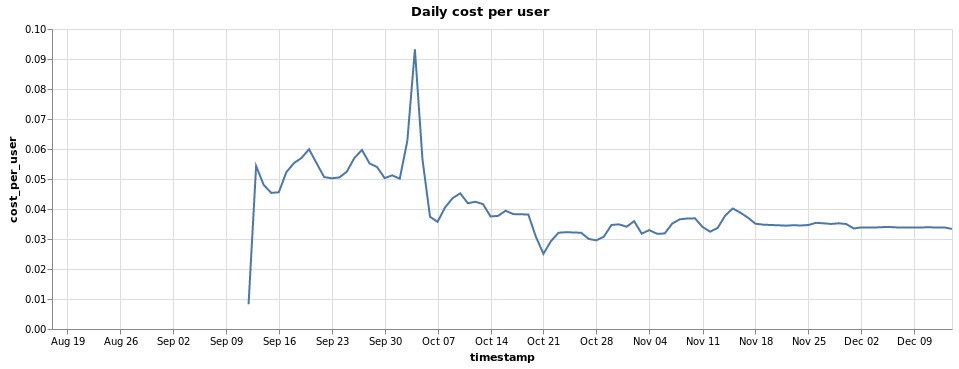

In [279]:
total['cost_per_user'] = total['cost'] / user_starts_count.count()['action']

alt.Chart(total, width=900, title='Daily cost per user').mark_line().encode(
    x='timestamp',
    y='cost_per_user'
)

We can also figure out how much they cost per month.

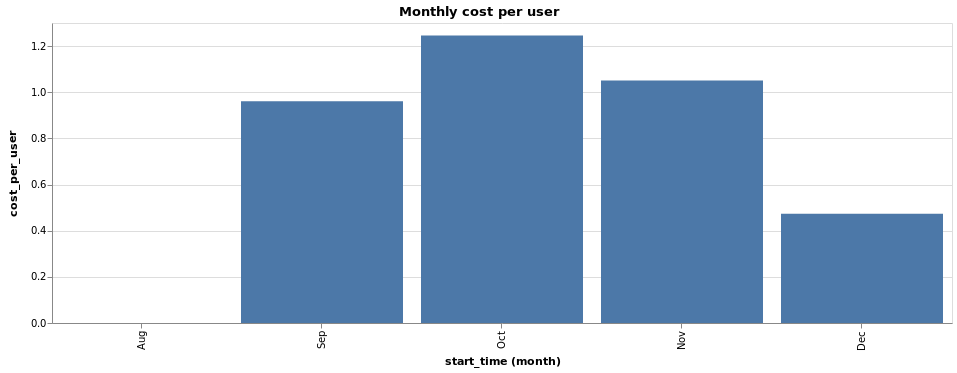

In [280]:
monthly = cost.copy().set_index('start_time').resample('M').sum()
monthly['cost_per_user'] = monthly['cost'] / user_starts_count.count()['action']
monthly = monthly.reset_index()

alt.Chart(monthly, width=900, title='Monthly cost per user').mark_bar().encode(
    x='month(start_time):O',
    y='cost_per_user'
)

## Realistic user count

A lot of people might log in a few times to the JupyterHub to check it out, and then never really come back. We should avoid counting those as 'users' when doing our cost analysis. 

We can cut off outliers at the 99th percentile and plot a histogram to see how most people use the hub

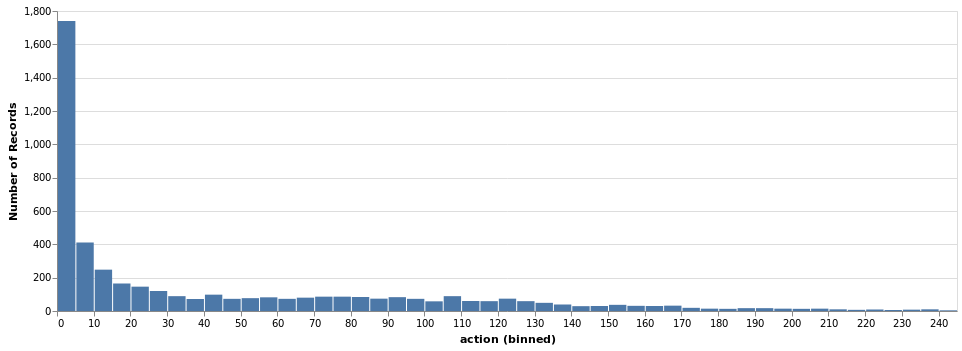

In [281]:
outlier_cutoff = user_starts_count.quantile(0.99)
alt.Chart(user_starts_count[user_starts_count.action < outlier_cutoff['action']], width=900).mark_bar().encode(
    alt.X('action', bin=alt.BinParams(maxbins=100)),
    y='count()'
)

There's a lot of users who use the hub <5 times, and many who use it 5-10 times. We pick an arbitrary cut off of 'ten notebook server starts' to count as a 'real' user and not someone just trying out the hub.

In [271]:
users_with_more_than_ten_starts = user_starts_count[user_starts_count.action > 10]
display.HTML(f'<h4>Users who used the hub more than 10 times: <b>{users_with_more_than_ten_starts.count()["action"]}')

We can use this to plot a daily and monthly cost per user

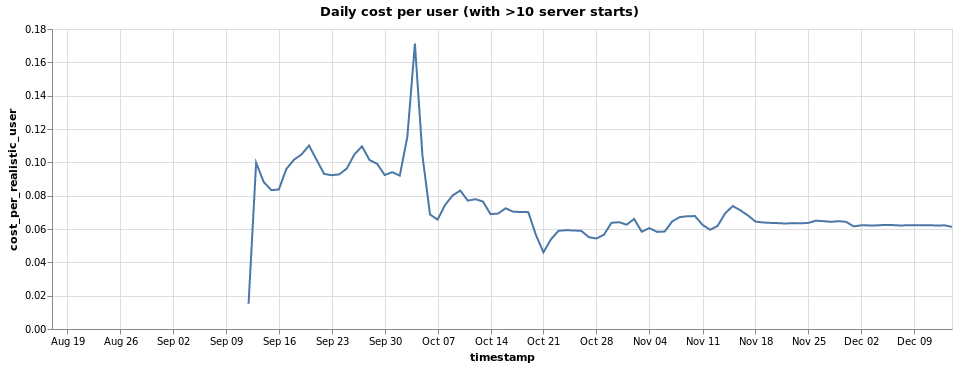

In [284]:
total['cost_per_realistic_user'] = total['cost'] / users_with_more_than_ten_starts.count()['action']

alt.Chart(total, width=900, title='Daily cost per user (with >10 server starts)').mark_line().encode(
    x='timestamp',
    y='cost_per_realistic_user'
)

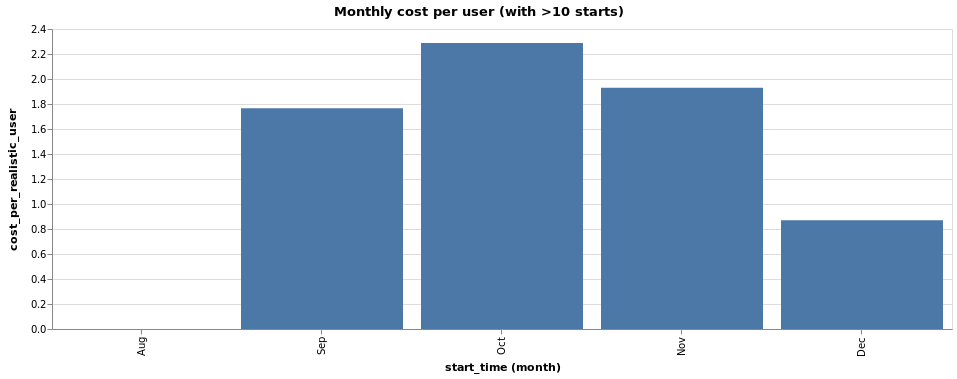

In [286]:
realistic_monthly = cost.copy().set_index('start_time').resample('M').sum()
realistic_monthly['cost_per_realistic_user'] = realistic_monthly['cost'] / users_with_more_than_ten_starts.count()['action']
realistic_monthly = realistic_monthly.reset_index()

alt.Chart(realistic_monthly, width=900, title='Monthly cost per user (with >10 starts)').mark_bar().encode(
    x='month(start_time):O',
    y='cost_per_realistic_user'
)

# Summary

Mean number of daily active users per day: **1006**

Monthly cost per 'realistic' user: **~2$**